# Compare cornerplots

Checking the posteriors between jim and bilby

## Preamble

In [1]:
import os
import copy
import numpy as np 
import json 
import matplotlib.pyplot as plt
import corner
import h5py

In [2]:
params = {"axes.grid": True,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}

plt.rcParams.update(params)

# Improved corner kwargs
default_corner_kwargs = dict(bins=40, 
                        smooth=1., 
                        show_titles=False,
                        label_kwargs=dict(fontsize=16),
                        title_kwargs=dict(fontsize=16), 
                        color="blue",
                        plot_density=True, 
                        plot_datapoints=False, 
                        fill_contours=True,
                        max_n_ticks=4, 
                        min_n_ticks=3,
                        density = True,
                        truth_color = "black")

In [3]:
bilby_keys_11d = ["chirp_mass",
              "mass_ratio",
              "chi_1",
              "chi_2",
              "luminosity_distance",
              "geocent_time",
              "phase",
              "theta_jn",
              "psi",
              "ra",
              "dec"
]

bilby_keys_4d = ["chirp_mass",
              "mass_ratio",
              "chi_1",
              "chi_2",
]

## Make the plot

Specify the directory id, i.e., `working_X`.

In [4]:
def my_report_runtime(time):
    hours = time // 3600
    minutes = (time % 3600) // 60
    seconds = time % 60
    return f"{hours:.0f}h {minutes:.0f}m {seconds:.0f}s"

The full list of bilby posterior keys:
<KeysViewHDF5 ['H1_matched_filter_snr', 'H1_optimal_snr', 'L1_matched_filter_snr', 'L1_optimal_snr', 'V1_matched_filter_snr', 'V1_optimal_snr', 'a_1', 'a_2', 'chi_1', 'chi_1_in_plane', 'chi_2', 'chi_2_in_plane', 'chi_eff', 'chi_p', 'chirp_mass', 'chirp_mass_source', 'comoving_distance', 'cos_tilt_1', 'cos_tilt_2', 'dec', 'geocent_time', 'iota', 'log_likelihood', 'log_prior', 'luminosity_distance', 'mass_1', 'mass_1_source', 'mass_2', 'mass_2_source', 'mass_ratio', 'maximum_frequency', 'minimum_frequency', 'phase', 'phi_1', 'phi_12', 'phi_2', 'phi_jl', 'pn_amplitude_order', 'pn_phase_order', 'pn_spin_order', 'pn_tidal_order', 'psi', 'ra', 'redshift', 'reference_frequency', 'spin_1x', 'spin_1y', 'spin_1z', 'spin_2x', 'spin_2y', 'spin_2z', 'symmetric_mass_ratio', 'theta_jn', 'tilt_1', 'tilt_2', 'total_mass', 'total_mass_source']>
The bilby sampling time was 12841.199119000205 seconds = 3h 34m 1s
Mean log prior bilby: -18.294883803860817
Mean log like

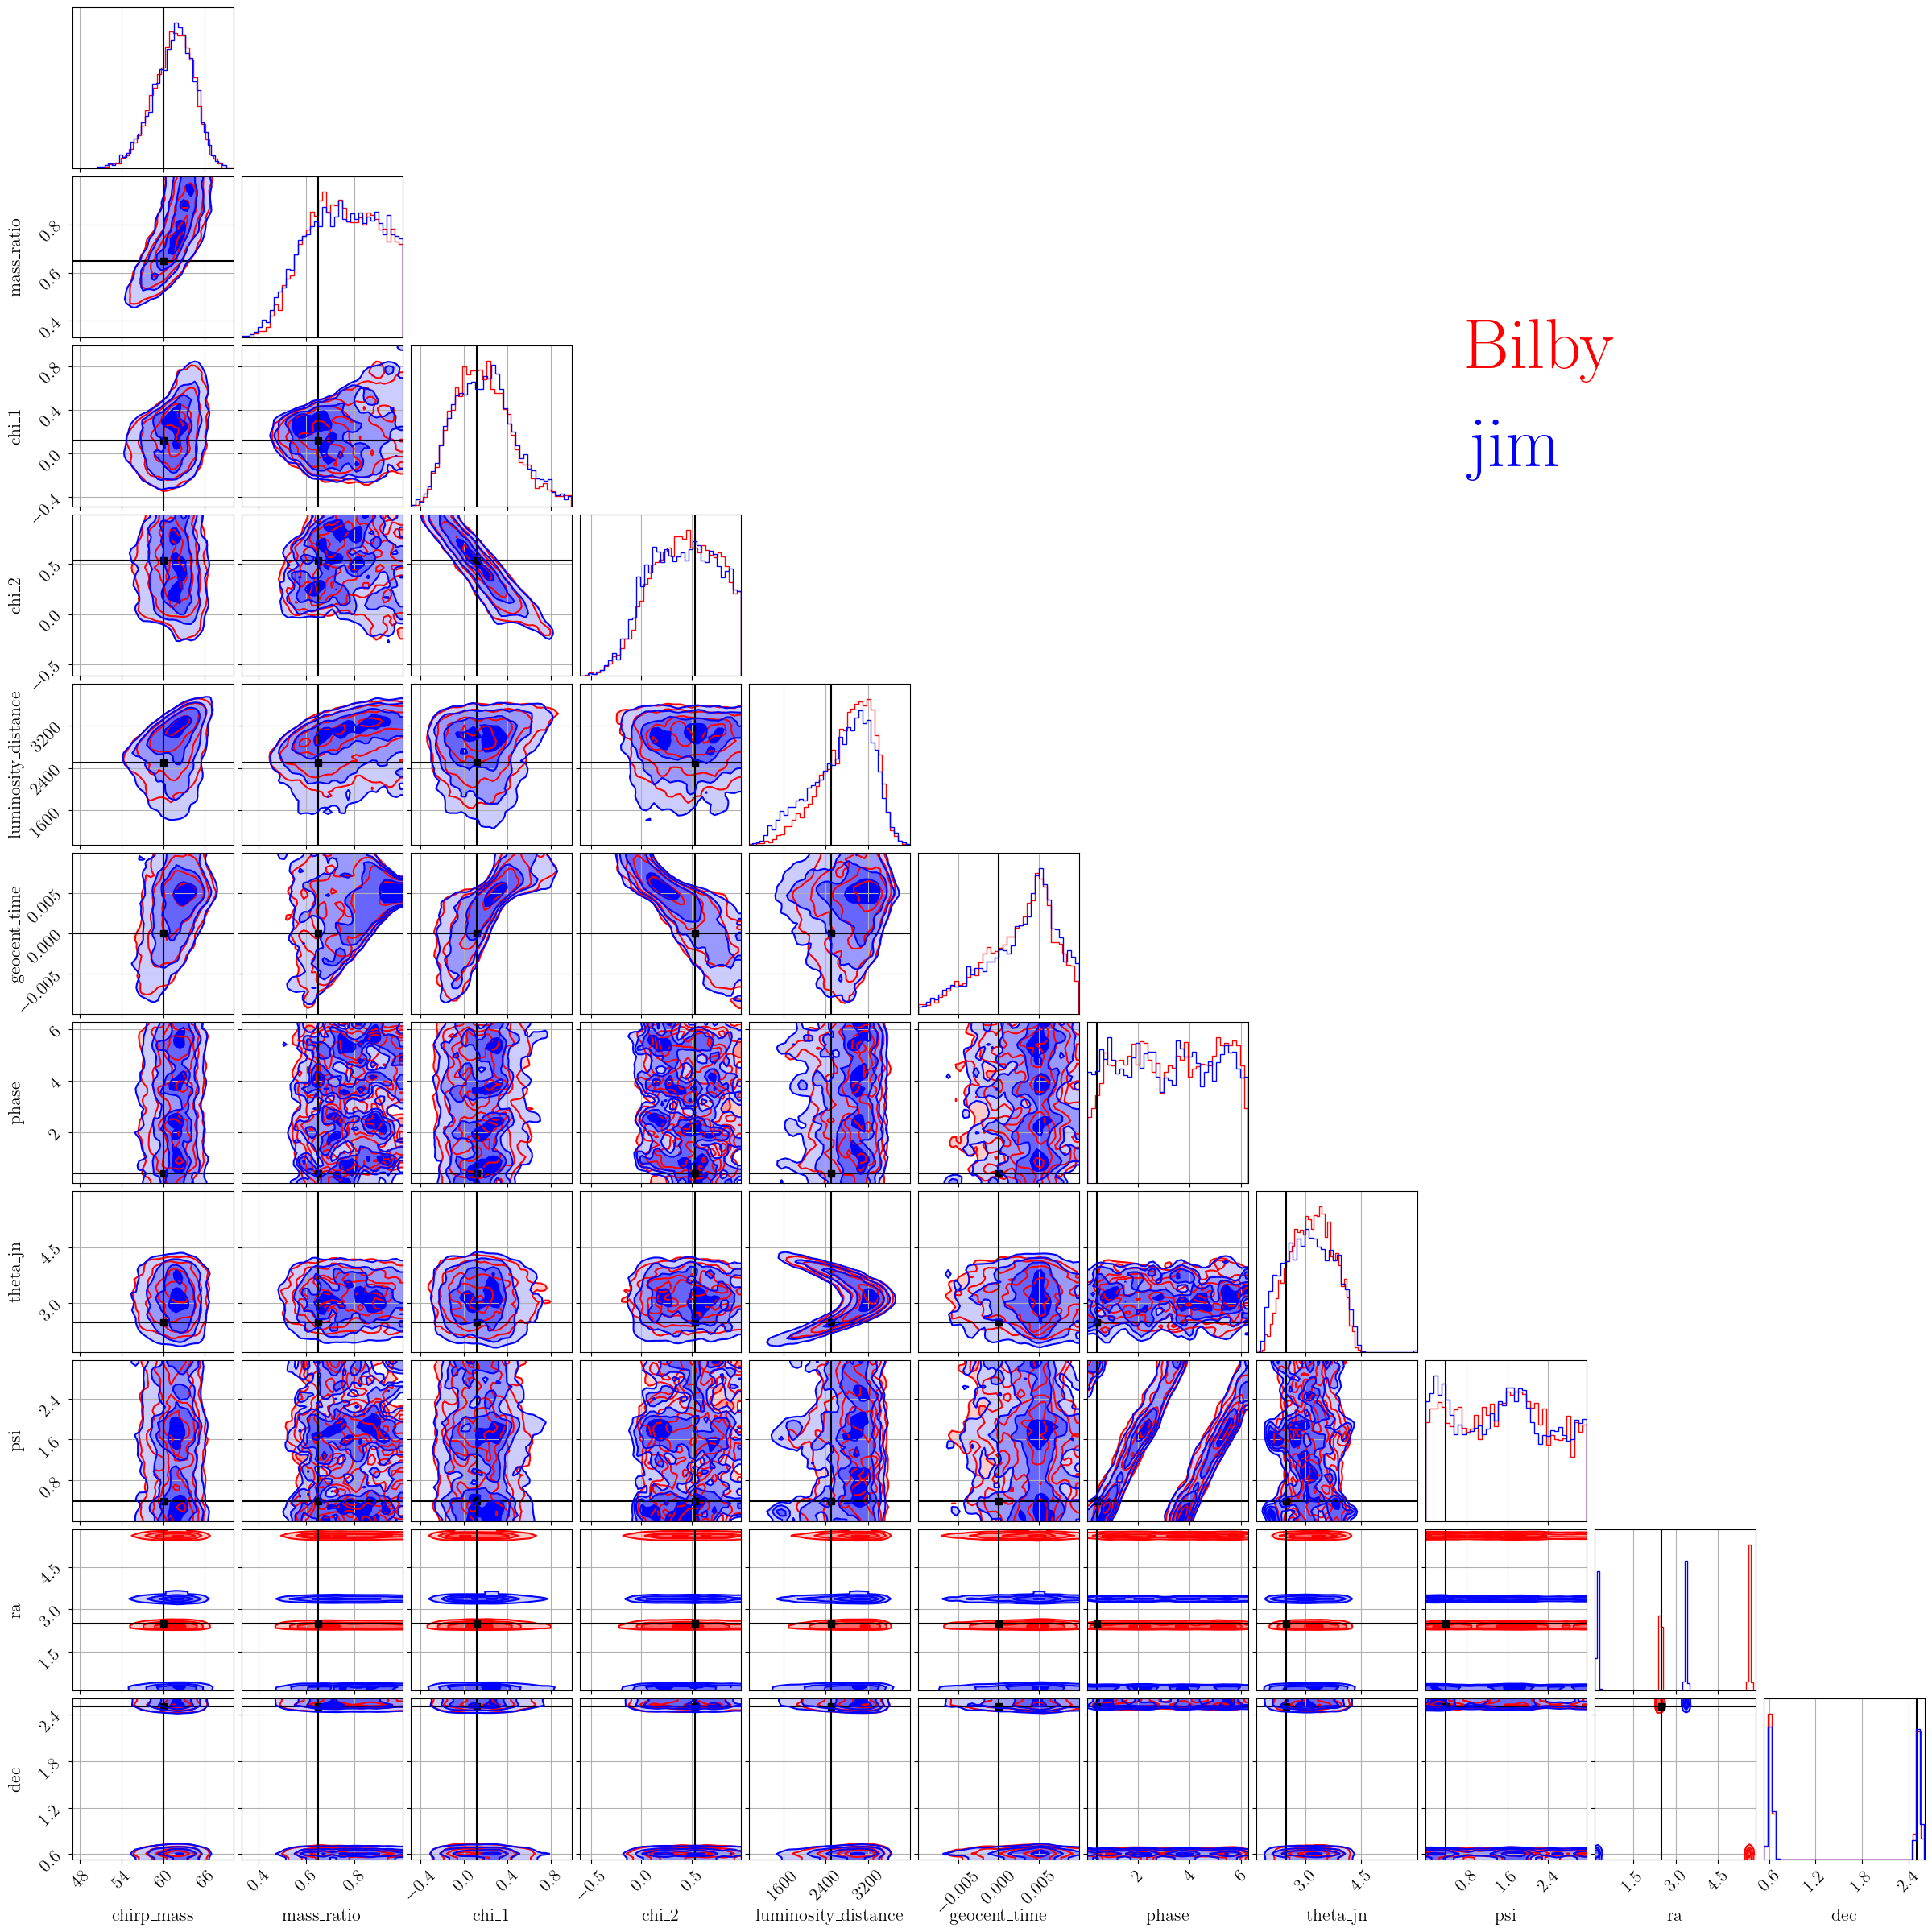

In [6]:
### Choose ID here, and get the outdir
which_run = "11d_example"
no_RB = True
outdir = os.path.join(os.getcwd(), which_run)

if "4" in which_run:
    bilby_keys = bilby_keys_4d
else:
    bilby_keys = bilby_keys_11d
###

### Load bilby
bilby_outdir = os.path.join(outdir, 'bilby')
bilby_results_file = os.path.join(bilby_outdir, 'bbh_0_result.hdf5')
with h5py.File(bilby_results_file, 'r') as f:
    bilby_posterior_dict = f["posterior"]
    
    print("The full list of bilby posterior keys:")
    print(bilby_posterior_dict.keys())
    
    bilby_posterior = np.array([bilby_posterior_dict[key] for key in bilby_keys]).T
    
    log_noise_evidence = f["log_noise_evidence"][()]
    log_evidence = f["log_evidence"][()]
    
    bilby_sampling_time = f["sampling_time"][()]
    print(f"The bilby sampling time was {bilby_sampling_time} seconds = {my_report_runtime(bilby_sampling_time)}")
    
    # Fetch truths
    truths_dict = f["injection_parameters"]
    truths = []
    for key in bilby_keys:
        truths.append(truths_dict[key][()])
    truths = np.array(truths)
    
    log_likelihood = bilby_posterior_dict["log_likelihood"][()]
    log_prior = bilby_posterior_dict["log_prior"][()]
    log_prob = log_likelihood + log_prior
    avg_log_prob = np.mean(log_prob)
    
    # Save in new variable for later on
    bilby_log_prob = log_prob
    
    print(f"Mean log prior bilby: {np.mean(log_prior)}")
    print(f"Mean log likelihood bilby: {np.mean(log_likelihood)}")
    print(f"Mean log prob bilby: {avg_log_prob}")
    
print(np.shape(bilby_posterior))

### Load jim
jim_outdir = os.path.join(outdir, 'jim')

jim_file = os.path.join(jim_outdir, 'results_production.npz')
jim_posterior = np.load(jim_file)["chains"]
jim_log_prob = np.load(jim_file)["log_prob"]
avg_log_prob_jim = np.mean(jim_log_prob)
print(f"Mean log prob jim: {avg_log_prob_jim}")
jim_posterior = np.reshape(jim_posterior, (-1, jim_posterior.shape[-1]))

print(f"Difference average log probs: {avg_log_prob - avg_log_prob_jim}")
print(np.shape(jim_posterior))

# Report runtime
jim_runtime_file = os.path.join(jim_outdir, 'runtime.txt')
jim_sampling_time = np.loadtxt(jim_runtime_file)
print(f"The bilby sampling time was {jim_sampling_time} seconds = {my_report_runtime(jim_sampling_time)}")

speedup = bilby_sampling_time / jim_sampling_time
print(f"Speedup factor: {int(speedup)}x")

# Thinning the jim samples a bit to make it easier for corner to handle
jump = 30
jim_posterior = jim_posterior[::jump, :]
print(np.shape(jim_posterior))

samples_dict = {"bilby": bilby_posterior, "jim": jim_posterior}
colors_dict = {"bilby": "red", "jim": "blue"}

for i, key in enumerate(["bilby", "jim"]):
    samples = samples_dict[key]
    color = colors_dict[key]

    corner_kwargs = copy.deepcopy(default_corner_kwargs)
    corner_kwargs["color"] = color
    corner_kwargs["hist_kwargs"] = {"color": color, "density": True}
    if i == 0:
        fig =  corner.corner(bilby_posterior, truths=truths, labels=bilby_keys, **corner_kwargs)
    else:
        corner.corner(jim_posterior, fig=fig, **corner_kwargs)

fs = 64
plt.text(0.75, 0.8, "Bilby", color="red", fontsize=fs, transform=plt.gcf().transFigure)
plt.text(0.75, 0.75, "jim", color="blue", fontsize=fs, transform=plt.gcf().transFigure)

# Save the figure
plt.savefig(os.path.join(outdir, "comparison_corner.png"), bbox_inches = 'tight')
plt.show()

## Histograms of log prob

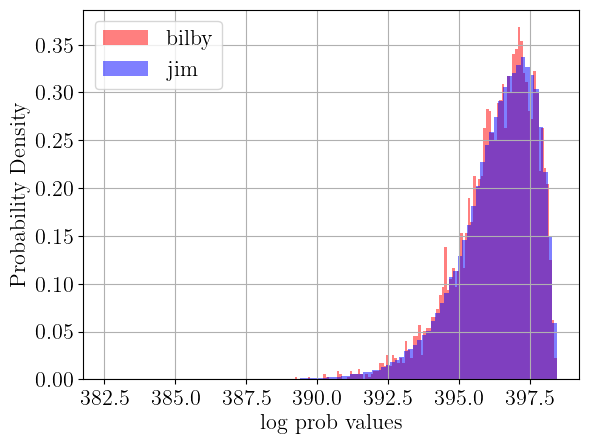

In [ ]:
bins = 100
alpha = 0.5

plt.hist(bilby_log_prob, bins=bins, alpha=alpha, color="red", label="bilby", density=True)
plt.hist(jim_log_prob.flatten(), bins=bins, alpha=alpha, color="blue", label="jim", density=True)
plt.legend()
plt.xlabel("log prob values")
plt.ylabel("Probability Density")
plt.show()